# Simulating Deuteron with XACC-VQE
To run this problem via docker, run the following from an empty directory

```bash
$ docker run --name xacc-notebook -it -p 8888:8888 -d -v $(pwd):/home/notebooks mccaskey/xacc-all-gate-jupyter-fc26
$ (to see jupyter notebook URL) docker logs xacc-notebook
```

## Preamble - import necessary libraries, create the Hamiltonian PauliOperator and the GateFunction Ansatz

In [1]:
import sys
sys.path.append('/usr/local/xacc/lib/python')
import numpy as np
import pyxacc as xacc
from pyxacc import InstructionParameter
import pyxaccvqe as vqe
from pyxaccvqe import PauliOperator
%matplotlib inline

# Construct the First Quantized 2x2 and 3x3 Hamiltonians
hamiltonian2x2 = PauliOperator(5.906709445) + PauliOperator({0:'X'}, -4.28660705) + \
                 PauliOperator({0:'Z'}, -6.343290555)
hamiltonian3x3 = PauliOperator(7.7658547225) + PauliOperator({0:'X'}, -2.143303525) + \
                PauliOperator({0:'X', 1:'X'}, -3.91311896) + PauliOperator({0:'X', 1:'Z'}, -2.143303525) + \
                PauliOperator({0:'Y',1:'Y'}, -3.91311896) + PauliOperator({0:'Z'}, 1.6408547224999999) + \
                PauliOperator({0:'Z',1:'Z'}, -7.9841452775) + PauliOperator({1:'Z'}, -1.8591452775000001)
            
print('H_{2x2} = ', hamiltonian2x2)
print('\nH_{3x3} = ', hamiltonian3x3)

# Create the 2x2 Ansatz
ansatz2x2 = xacc.gate.GateFunction('statePrep', [InstructionParameter('theta')])
ansatz2x2.add(xacc.gate.create('Ry',[0],[InstructionParameter('theta')]))
print('\n2x2 Ansatz = \n', ansatz2x2.toString('q'))

# Create the 3x3 Ansatz
ansatz3x3 = xacc.gate.GateFunction('statePrep', [InstructionParameter('theta0'), InstructionParameter('theta1')])
ansatz3x3.add(xacc.gate.create('Ry',[0],[InstructionParameter('theta0')]))
ansatz3x3.add(xacc.gate.create('Ry',[1],[InstructionParameter('theta1')]))
print('3x3 Ansatz = \n', ansatz3x3.toString('q'))

angle_range = np.linspace(-np.pi,np.pi,50)

H_{2x2} =  (5.90671,0) + (-6.34329,0) Z0 + (-4.28661,0) X0

H_{3x3} =  (-1.85915,0) Z1 + (-7.98415,0) Z0 Z1 + (-2.1433,0) X0 + (7.76585,0) + (1.64085,0) Z0 + (-2.1433,0) X0 Z1 + (-3.91312,0) X0 X1 + (-3.91312,0) Y0 Y1

2x2 Ansatz = 
 Ry(theta) q0

3x3 Ansatz = 
 Ry(theta0) q0
Ry(theta1) q1



## Compute $E_{2x2}(\theta)$

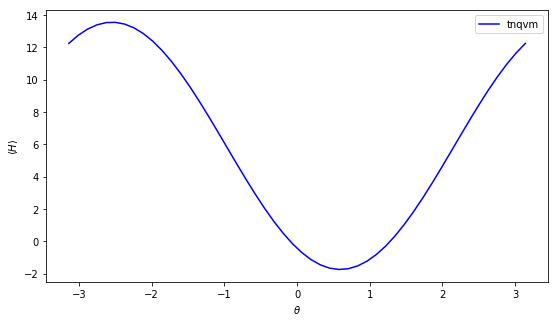

In [2]:
energies = [vqe.execute(hamiltonian2x2, **{'task':'compute-energy', 
                                        'vqe-params':str(t), 
                                        'ansatz':ansatz2x2, 'n-qubits':2}).results[0][1] 
            for t in angle_range]

import matplotlib.pyplot as plt
plt.figure(figsize=(9,5))
plt.xlabel(r'$\theta$')
plt.ylabel(r'$\langle H\rangle$')
plt.plot(angle_range, energies, '-', color='b', label=r'tnqvm')
plt.legend()
plt.show()

## $H_{2x2}$ VQE

In [3]:
# NOTE using 2 qubits here due to bug in TNQVM for 1 qubit
vqeResult = vqe.execute(hamiltonian2x2, **{'task':'vqe', 'ansatz':ansatz2x2, 'n-qubits':2})
print('(Optimal Angle, Energy) = (', vqeResult.results[0][0], ',', vqeResult.results[0][1], ')')

(Optimal Angle, Energy) = ( [0.59457095] , -1.7491595492912522 )


## Compute $E_{3x3}(\theta_0,\theta_1)$

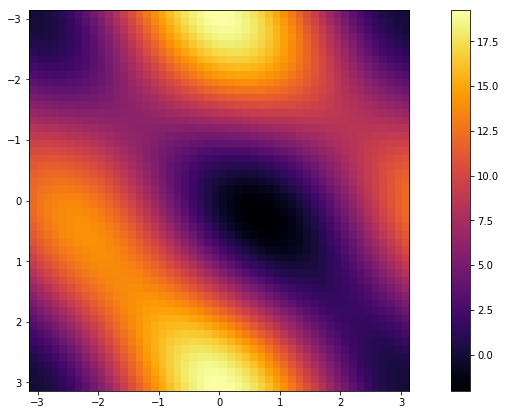

In [4]:
energies = [[vqe.execute(hamiltonian3x3, **{'task':'compute-energy', 
                                        'vqe-params':str(t0)+','+str(t1), 
                                        'ansatz':ansatz3x3, 'n-qubits':2}).results[0][1] 
            for t0 in angle_range] for t1 in angle_range]

import matplotlib.pyplot as plt
plt.figure(figsize=(15,7))
import matplotlib
cmap = matplotlib.cm.get_cmap('inferno')  # this loads the cubehelix color map which prints well in b/w 
ax = plt.subplot()
plt.imshow(energies,interpolation='nearest',cmap=cmap,extent=(
    angle_range.min(),angle_range.max(),angle_range.max(),angle_range.min()))
ax.set_xlabel=r'$\alpha_1'
ax.set_ylabel=r'$\alpha_2'
plt.xlabel=r'$\alpha_1'
plt.ylabel=r'$\alpha_2'
plt.colorbar()
plt.show()

## $H_{3x3}$ VQE

In [5]:
vqeResult3x3 = vqe.execute(hamiltonian3x3, **{'task':'vqe', 'ansatz':ansatz3x3, 'vqe-params':'0,0', 'n-qubits':2})
print('(Optimal Angle, Energy) = (', vqeResult3x3.results[0][0], ',', vqeResult3x3.results[0][1], ')')

(Optimal Angle, Energy) = ( [0.71405211 0.26920504] , -2.0410651707525056 )
